# iCAT Preprocess
---
Overview and interactive walkthrough of how to configure Odemis tile data for use in `render-ws`.

Annoyingly, ...

Assumes that high magnification EM tiles are stored by themselves, while all FM channels are together with the low magnification EM channel in a multi-page tiff.

Starting config
```
project
    ├───┬ lil_EM
    │   ├──── tile-00000x00000.ome.tiff
    │   ├──── tile-00000x00001.ome.tiff
    │   ├──── ...
    │   ├──── tile-00022x00025.ome.tiff
    │   └──── tile-00022x00026.ome.tiff
    ├──── big_tile-00000x00000.ome.tiff
    ├──── big_tile-00000x00001.ome.tiff
    ├──── ...
    ├──── big_tile-00002x00001.ome.tiff
    └──── big_tile-00002x00002.ome.tiff

```

Desired config
```
project
    ├───┬ amylase
    │   └─── amylase-00000x00000.ome.tif
    ├───┬ big_EM
    │   └──── big_EM-00000x00000.ome.tif
    ├───┬ hoechst
    │   └──── hoechst-00000x00000.ome.tif
    ├───┬ insulin
    │   └──── insulin-00000x00000.ome.tif
    └───┬ lil_EM
        ├──── lil_EM-00008x00011.ome.tif
        ├──── lil_EM-00008x00012.ome.tif
        ├──── ...
        ├──── lil_EM-00012x00015.ome.tif
        └──── lil_EM-00012x00016.ome.tif
```

#### Notes
* Only tested on `ome.tiff` file type.

## 1 Reconfigure Image Tiles
### 1.0 Imports

In [1]:
from pathlib import Path
import numpy as np
import re
from bs4 import BeautifulSoup as Soup
import xml.etree.ElementTree as ET

from skimage.external.tifffile import TiffFile, TiffWriter
from skimage.io import imread

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
odemis_path = Path('/long_term_storage/rlane/SECOM/pancrea_20180429_odemis/')

project_path = Path('/long_term_storage/rlane/SECOM/pancrea_20180429/')
project_path.mkdir(parents=True, exist_ok=True)

### 1.1 Handle Single-channel Data
This is assumed to be the high magnification EM tiles. All we have to do is rename the tiles such that they go by the convention  
`.../<project>/<stack>/<stack>-<col>x<row>.ome.tif`

In [3]:
# Target names
stack = 'lil_EM'
tile = 'lil_EM'
ext = 'ome.tif'

# Gather all high mag EM tiles
tile_fns = (odemis_path / 'lil_EM').glob('*.ome.tiff')

# Rename and move to project directory
# Check before uncommenting
for tile_fn in tile_fns:
    # Set target path
    target_parent = project_path / target_names['stack']
    target_parent.mkdir(parents=True, exist_ok=True)
    col, row = re.findall('\d+', tile_fn.name)[:-2]
    target_name = f'{tile}-{col}x{row}.{ext}'
    # Rename
    # tile_fn.rename(target_parent / target_name)
    print(target_parent / target_name)

### 1.2 Handle Multi-channel Data
This is assumed to be all the FM tiles (all channels) plus the low magnification EM tiles. This is much harder. Not only do we have to rename the tiles in the same way we just did for the high mag EM tiles, but we also have to separate the channels, extract the metadata, and substitute the metadata back into each of the channels.

#### Determine channels within multi-channel data
Not really sure of a good way to do this autonomously if the page name is the usual `Filtered colour #`. Probably best to open an image in the viewer and go off that.

In [4]:
multi_channel_fns = odemis_path.glob('big_tile*')

tif = TiffFile(list(multi_channel_fns)[0].as_posix())
print(f'TIFF path: {odemis_path}')
print(tif)

for page in tif.pages:
    print(page.tags['page_name'].value)

TIFF path: /long_term_storage/rlane/SECOM/pancrea_20180429_odemis
TIFF file: big_tile-00000x00000.ome.tiff, 26 MiB, little endian, ome, 4 pages, 4 series
b'Filtered colour 1'
b'Filtered colour 3'
b'Filtered colour 2'
b'Secondary electrons'


#### Create channel map

In [5]:
# ----------- Channel in metadata :  stack
channel_map = {'Filtered colour 1': 'hoechst',
               'Filtered colour 2': 'amylase',
               'Filtered colour 3': 'insulin',
               'Secondary electrons': 'big_EM'
}

#### Break up Multi-page TIFF into Separate TIFFs
First define some utility functions.

In [6]:
def get_metadata(fn):
    """
    Retrieves metadata from tiff file using TiffFile package and BeautifulSoup
    
    Parameters
    ----------
    fn : `pathlib.Path`
        Path to tile storage location in `pathlib.Path` representation
    
    Returns
    -------
    md : `bs4.BeautifulSoup`
        TIFF Metadata
    """
    tiff = TiffFile(fn.as_posix())
    page = tiff.pages[0]
    xml = page.tags['image_description'].value
    md = Soup(xml, 'lxml')
    return md


def rewrite_metadata(multipage_md, channel):
    """
    Break up and rewrite metadata based on channel
    
    Parameters
    ----------
    multipage_md : `bs4.BeautifulSoup`
        TIFF Metadata from multi-page tiff
    channel : str
        Channel name in metadata (e.g. "Filtered colour 1")
    
    Returns
    -------
    md : `bs4.BeautifulSoup`
        Edited TIFF Metadata
    """
    # Add OME schema info
    root = ET.Element('OME', attrib={
            "xmlns": "http://www.openmicroscopy.org/Schemas/OME/2012-06",
            "xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
            "xsi:schemaLocation": "http://www.openmicroscopy.org/Schemas/OME/2012-06 "
                                  "http://www.openmicroscopy.org/Schemas/OME/2012-06/ome.xsd",
            })
    
    # Add OME comment
    com_txt = ("Warning: this comment is an OME-XML metadata block, which "
               "contains crucial dimensional parameters and other important "
               "metadata. Please edit cautiously (if at all), and back up the "
               "original data before doing so. For more information, see the "
               "OME-TIFF web site: http://ome-xml.org/wiki/OmeTiff.")
    root.append(ET.Comment(com_txt))
    
    # Add instrument and microscope tags
    instr = ET.SubElement(root, "Instrument", attrib={"ID": "Instrument:0"})
    micro = ET.SubElement(instr, "Microscope", attrib={
        "Manufacturer": "Delmic",
        "Model": "SECOM"})
    
    # Select image metadata based on channel
    image_md = None
    for image in multipage_md.find_all('image'):
        if image.attrs['name'] == channel:
            image_md = image
    
    # Add image metadata to ElementTree
    root.append(ET.fromstring(image_md.decode()))
    
    # Get detector, lightsource, and objective ids for cross-referencing
    detector_id = None if image_md.find('detectorsettings') is None \
                     else image_md.find('detectorsettings').get('id')
    lightsource_id = None if image_md.find('lightsourcesettings') is None \
                        else image_md.find('lightsourcesettings').get('id')
    objective_id = None if image_md.find('objectivesettings') is None \
                      else image_md.find('objectivesettings').get('id')
    
    # Add detector metadata based on id
    for detector in multipage_md.find_all('detector'):
        if detector.attrs['id'] == detector_id:
            instr.append(ET.fromstring(detector.decode()))
    # Add lightsource metadata based on id
    for lightsource in multipage_md.find_all('lightsource'):
        if lightsource.attrs['id'] == lightsource_id:
            instr.append(ET.fromstring(lightsource.decode()))
    # Add objective metadata based on id
    for objective in multipage_md.find_all('objective'):
        if objective.attrs['id'] == objective_id:
            instr.append(ET.fromstring(objective.decode()))
    
    # Convert ElementTree back to Soup and return
    tree = ET.ElementTree(root)
    et = (b'<?xml version="1.0" encoding="UTF-8"?>' +
          ET.tostring(tree.getroot(), encoding='utf-8'))
    md = Soup(et, 'lxml')
    return md

    
def save_tiff(fn, data, metadata):
    """
    Save ome tiff with provided image and metadata
    
    Parameters
    ----------
    fn : `pathlib.Path`
        Path to tile storage location in `pathlib.Path` representation
    data : ndarray
        Image data
    metadata : `bs4.BeautifulSoup`
        TIFF Metadata
    """
    # Convert metadata to `bytes` object
    md = metadata.encode(encoding='utf-8')
    print(f'Saving {fn}')
    with TiffWriter(fn.as_posix()) as out:
        out.save(data, description=md)
        
        
def split_tiff(fn, channel_map):
    """
    Break up multi-page tiff into separate tiffs
    
    Parameters
    ----------
    fn : `pathlib.Path`
        Path to tile storage location in `pathlib.Path` representation
    """
    tiff = TiffFile(fn.as_posix())
    md = get_metadata(fn)
    
    for page in tiff.pages:
        
        # Get channel
        channel = page.tags['page_name'].value.decode('utf-8')
        stack = channel_map[channel]
        
        # Set filename for page
        page_parent = project_path / stack
        col, row = re.findall('\d+', fn.name)[-2:]
        page_name = f'{stack}-{col}x{row}.ome.tif'
        page_fn = page_parent / page_name
        
        # Set new metadata
        page_md = rewrite_metadata(md, channel)
        
        # Save as separate tiff
        save_tiff(page_fn, page.asarray(), page_md)

In [7]:
# Have to regenerate list of multi-channel image tiles
multi_channel_fns = odemis_path.glob('big_tile*')

# Loop through multi-channel image tiles and separate
for fn in multi_channel_fns:
    split_tiff(fn, channel_map=channel_map)

Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/big_EM/big_EM-00000x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/big_EM/big_EM-00000x00001.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/hoechst/hoechst-00001x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/insulin/insulin-00001x00000.ome.tif
Saving /long_term_storage/rlane/SECOM/pancrea_20180429/amylase/amylase-00001x00000.ome.tif
Sav

## 2 Check Reconfigured TIFFs

In [8]:
# Collect stacks
stacks = channel_map.values()

# Collect one newly created tiff from each stack
sample_tile_fns = {}
for stack in stacks:
    sample_tile_fns[stack] = list((project_path/stack).glob('*'))[0]

# Ensure each tiff has only 1 page
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    if not len(tif.pages) == 1:
        if len(tif.pages) > 1:
            raise ValueError("Tiff has more than 1 page")
        else:
            raise ValueError("Tiff has no pages")

#### Gather metadata

In [9]:
# Gather metadata
sample_metadata = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    page = tif.pages[0]
    xml = page.tags['image_description'].value
    sample_metadata[stack] = Soup(xml, 'lxml')

In [10]:
md = sample_metadata['amylase']
print(md.prettify())

<?xml version="1.0" encoding="UTF-8"?>
<html>
 <body>
  <ome xmlns="http://www.openmicroscopy.org/Schemas/OME/2012-06" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemalocation="http://www.openmicroscopy.org/Schemas/OME/2012-06 http://www.openmicroscopy.org/Schemas/OME/2012-06/ome.xsd">
   <!--Warning: this comment is an OME-XML metadata block, which contains crucial dimensional parameters and other important metadata. Please edit cautiously (if at all), and back up the original data before doing so. For more information, see the OME-TIFF web site: http://ome-xml.org/wiki/OmeTiff.-->
   <instrument id="Instrument:0">
    <microscope manufacturer="Delmic" model="SECOM">
    </microscope>
    <detector id="Detector:2" model="Andor ZYLA-4.2P-USB3- (s/n: VSC-06794)">
    </detector>
    <lightsource id="LightSource:2" power="525.000000000000000">
    </lightsource>
    <objective calibratedmagnification="60.000000000000000" id="Objective:2" model="Optical Objective">
    </o

#### Preview tiles

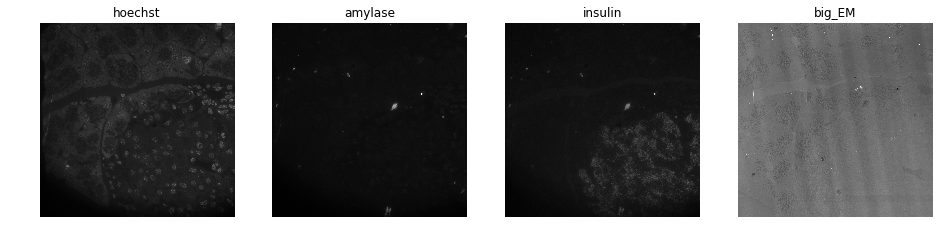

In [11]:
# Gather image tiles
sample_images = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    sample_images[stack] = tif.pages[0].asarray()
    
# Make figure
fig, axes = plt.subplots(ncols=len(channel_map), figsize=(16, 6))
for stack, ax in zip(stacks, axes.flat):
    ax.imshow(sample_images[stack], cmap='Greys_r')
    ax.set_title(stack)
    ax.axis('off')

#### Preview tiles with enhanced contrast

In [12]:
def get_intensity_range(img, outliers):
    """
    Find the intensity range fitting best an image based on the histogram and the specified outliers.
    
    Parameters
    ----------
    img : (M, N[, C]) ndarray
        Input image
    outliers : float
        Ratio of outliers to discard (on both sides)
        Must be within range (0 < outliers < 0.5)
        0 ----> discards no value
        0.5 --> discards every value (and so returns median)
        
    Returns
    -------
    rng : tuple
        Min and max values
    
    Notes
    -----
    Combination of `odemis.util.histogram` and `odemis.util.findOptimalRange`
    """
    # Get histogram and histogram edges
    idt = np.iinfo(img.dtype)
    irange = (idt.min, idt.max)
    length = irange[1] - irange[0] + 1
    hist = np.bincount(img.flat, minlength=length)
    edges = (0, hist.size - 1)
    
    if outliers == 0:
        inz = np.flatnonzero(hist)
        idxrng = inz[0], inz[-1]
    
    else:
        outliers /= 100
        cum_hist = hist.cumsum()
        nval = cum_hist[-1]
        
        # Remove 0 pixels from histogram if >0.1% and no pixels have value 1
        if hist[1] == 0 and cum_hist[0] / nval > 0.001:
            cum_hist -= cum_hist[0]
            nval = cum_hist[-1]
            
        oval = int(round(outliers * nval))
        lowv, highv = oval, nval - oval
        
        lowi = np.searchsorted(cum_hist, lowv, side='right')
        if hist[lowi] == lowv:
            lowi += 1
        highi = np.searchsorted(cum_hist, highv, side='left')
        
        idxrng = lowi, highi
    
    a = edges[0]
    b = (edges[1] - edges[0]) / (hist.size - 1)
    rng = (a + b * idxrng[0], a + b * idxrng[1])
    return rng

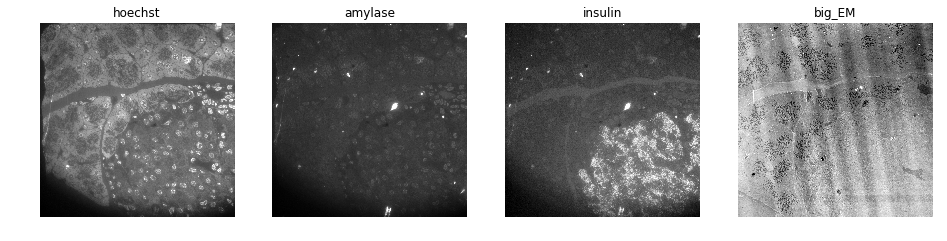

In [13]:
# Gather image tiles
sample_images = {}
for stack, tile_fn in sample_tile_fns.items():
    tif = TiffFile(tile_fn.as_posix())
    img = tif.pages[0].asarray()
    rng = get_intensity_range(img, 0.1)
    sample_images[stack] = np.clip(img, rng[0], rng[-1])
    
# Make figure
fig, axes = plt.subplots(ncols=len(channel_map), figsize=(16, 6))
for stack, ax in zip(stacks, axes.flat):
    ax.imshow(sample_images[stack], cmap='Greys_r')
    ax.set_title(stack)
    ax.axis('off')